# Problem: Credit Card Fraud Detection
Credit card fraud is a critical issue faced by financial institutions and consumers worldwide. Fraudulent transactions cause significant financial losses and help reduce trust in payment systems. Detecting fraudulent transactions in real time is challenging due to the high volume of transactions and the evolving tactics used by scammers.

Machine learning provides a powerful approach to detect credit card fraud by using historical transaction data to identify patterns indicative of fraud. Here's a step by step on how we can solve this issue using machine learning:


## 1. Problem Identification
The goal of this project is to develop a **binary classification model** that is able to predict whether a transaction is **fraudulent** or **legitimate**


## 2. Data Collection and Preparation
- **Dataset Source**: [Kaggle Credit Card Fraud Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
- **Dataset Description**:
  - Contains over **280,000 transactions**.
  - Includes **features** such as `Amount`, `Time`, and 28 anonymized numerical features (`V1` to `V28`).
  - A binary target variable (`Class`), where:
    - `0` = Legitimate Transaction
    - `1` = Fraudulent Transaction


## 3. Model Design and Architecture
- **Model Type**: Neural Network
- **Architecture**:
  - Input layer: 30 features (including `Amount`, `Time`, and the 28 anonymized features).
  - Hidden layers: 2 configured fully connected  hidden layer and ReLU activation.
  - Output layer: A single neuron with **Sigmoid activation** for binary classification.
- **Loss Function**: Binary Cross-Entropy Loss.


## 4. Training and Testing
### Steps:
1. Split the dataset into **train**, and **test** sets.
2. Train the model using **train** data.
3. Test the model using **test** data.
4. Deploy the trained model for real-time predictions.






In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from google.colab import drive
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy, Precision, Recall
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Loading and Initial Exploration of the Credit Card Fraud Dataset

In [ ]:
drive.mount('/gdrive')
path = '/gdrive/My Drive/creditcard.csv'
df = pd.read_csv(path)

# print(  len(df) /(len(df) +len(df[df['Class'] == 1]))   )
df[['Time', 'V1', 'V2','V3','V27','V28','Amount','Class']].head()



Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


,Time,V1,V2,V3,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.219422,0.215153,69.99,0


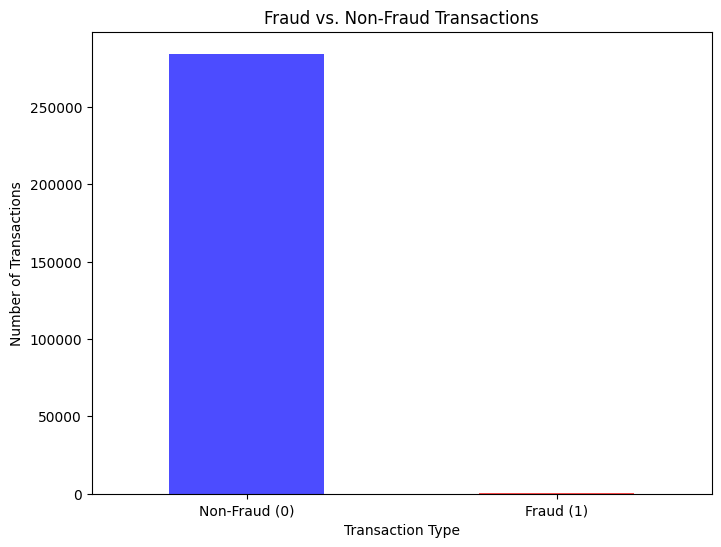

In [ ]:
fraud_counts = df['Class'].value_counts()


plt.figure(figsize=(8, 6))
fraud_counts.plot(kind='bar', color=['blue', 'red'], alpha=0.7)
plt.xticks(ticks=[0, 1], labels=['Non-Fraud (0)', 'Fraud (1)'], rotation=0)
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.title('Fraud vs. Non-Fraud Transactions')
plt.show()

# Dataset Imbalance

The dataset exhibits an extremelyclass imbalance. There are over 280,000 non-fraudulent transactions, while fraudulent transactions are less than 500. Initially Model training was impacted by this issue, which led to all its predictions being classified as non-fraudulent and receiving a precision of 0.00 percent.

To address this issue, we used a scaler object from the scikit-learn library to scale the data effectively.

# Feature and Target Variable Extraction


In [ ]:
x = df.drop('Class', axis=1)
y = df['Class']


# Data Scaling for Improved Model Performance

In [ ]:
# Scale the data
scaler = StandardScaler()
x = scaler.fit_transform(x)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

# Data Splitting and Tensor Conversion

In [ ]:
y = y.values

# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)
print(f' Number of tests {len(y_test)}')


# Convert data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)



 Number of tests 56962


# Model Architecture

In [ ]:
class FraudDetectionModel(pl.LightningModule):
    def __init__(self, input_size=30, hidden_sizes=[94, 42], lr=1e-3):
        super(FraudDetectionModel, self).__init__()
        self.lr = lr

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], 1),
            nn.Sigmoid()
        )

        self.accuracy = Accuracy(task="binary")
        self.precision = Precision(task="binary")
        self.recall = Recall(task="binary")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()  # Remove extra dimension
        loss = F.binary_cross_entropy(y_pred, y)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = F.binary_cross_entropy(y_pred, y)
        self.log("val_loss", loss, on_epoch=True)
        self.log("val_acc", self.accuracy(y_pred, y), on_epoch=True)
        self.log("val_precision", self.precision(y_pred, y), on_epoch=True)
        self.log("val_recall", self.recall(y_pred, y), on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


# Model Training and Validation

In [ ]:
model = FraudDetectionModel(input_size=X_train.shape[1], lr=1e-3)

# Set up the trainer
trainer = pl.Trainer(max_epochs=6)

# Train the model
trainer.fit(model, train_loader, val_loader)
print(f"Final Accuracy: {trainer.callback_metrics['val_acc']:.4f}")
print(f"Final Precision: {trainer.callback_metrics['val_precision']:.4f}")
print(f"Final Recall: {trainer.callback_metrics['val_recall']:.4f}")
print(f"Final Loss: {trainer.callback_metrics['val_loss']:.4f}")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Sequential      | 6.9 K  | train
1 | accuracy  | BinaryAccuracy  | 0      | train
2 | precision | BinaryPrecision | 0      | train
3 | recall    | BinaryRecall    | 0      | train
------------------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


Final Accuracy: 0.9994
Final Precision: 0.0416
Final Recall: 0.0416
Final Loss: 0.0027


# Model Testing

In [ ]:
# Load the test data into DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)
print(y_test_tensor.values)


model.eval()  # Set the model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        y_hat = model(x).squeeze()  # Get model predictions
        all_preds.append(y_hat)
        all_labels.append(y)


all_preds = torch.cat(all_preds).cpu()
all_labels = torch.cat(all_labels).cpu()


all_preds_binary = (all_preds > 0.5).float()

accuracy = accuracy_score(all_labels, all_preds_binary)
precision = precision_score(all_labels, all_preds_binary)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds_binary)

# cm is a 2x2 matrix:
# [ [TN, FP],
#   [FN, TP] ]
# Extract False Negatives from the confusion matrix


<built-in method values of Tensor object at 0x7ff4daee5260>


# Performance Metrics and Analysis

In [ ]:
print(f"\nConfusion matrix")
print(f"True Negatives: {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives: {cm[1, 1]}")

print("\nFinal Metrics")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")



Confusion matrix
True Negatives: 56854
False Positives: 10
False Negatives: 22
True Positives: 76

Final Metrics
Accuracy: 0.9994
Precision: 0.8837


# Saving Model

In [ ]:
# Save the model's state_dict
torch.save(model.state_dict(), "fraud_detection_model.pth")
from google.colab import files
files.download("fraud_detection_model.pth")
files.download("scaler.pkl")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
! pip install torch pytorch-lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 47.0 MB/s eta 0:00:00
